# Cross Entropy Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
torch.manual_seed(0)

## 负对数似然

$-log(P)$

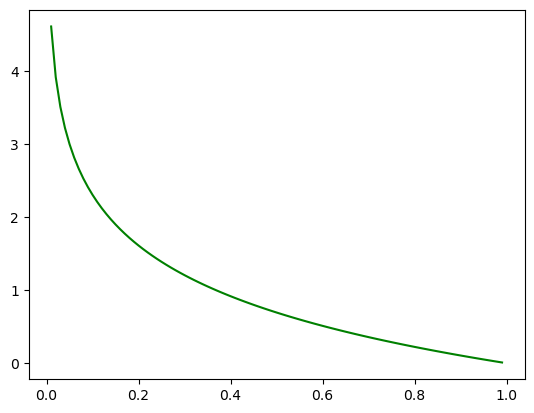

In [2]:
import matplotlib.pyplot as plt

x = torch.arange(0,100)/100.0
p = -x.log()

plot1=plt.plot(x.tolist(),p.tolist(),'-g',label="log(x)")
plt.show()
# 随着概率增大，负对数似然变小。
# 我们的目标是提高预测分类的概率，那么其负对数似然变小。

## 熵计算

$$
H = -\sum_i p_i \log(q_i)
$$

p是真实分布

In [3]:
q = 0.5
p = 0.9

entropy = -p*math.log(q)
print(entropy)

0.6238324625039507

In [4]:
# 给定两个概率分布，计算交叉熵

q = torch.tensor([0.5, 0.2, 0.1])
p = torch.tensor([0.1, 0.9, 0.0])#目标分布

entropy = -p * torch.log(q)
print(entropy)
print(entropy.sum())

tensor([0.0693, 1.4485, 0.0000])

tensor(1.5178)

In [5]:
# 给定两个概率分布

q = torch.tensor([0.3, 0.5, 0.2])# 如果预测不对
p = torch.tensor([0.0, 1.0, 0.0])# 目标分布，如果3分类的标签是2，那么第二个类别的概率为1

entropy = -p*torch.log(q) #p1*logq1+p2*logq2+p3*logq3
print(entropy)
print(entropy.sum())

tensor([0.0000, 0.6931, 0.0000])

tensor(0.6931)

In [6]:
# 给定两个概率分布

q = torch.tensor([0.05, 0.9, 0.05])# 如果预测的较准确
p = torch.tensor([0.0, 1.0, 0.0])# 目标分布

entropy = -p * torch.log(q)
print(entropy)
print(entropy.sum())# # 如果预测的较准确, 熵更低

tensor([0.0000, 0.1054, 0.0000])

tensor(0.1054)

In [7]:
# 在具体的分类问题里,如果类别是1
# 可以直接找-logq[1]做为交叉熵

q = torch.tensor([0.05, 0.9, 0.05])# 如果预测的较准确
label = 1 # q=[0.0, 1.0, 0.0]

entropy = - torch.log(q[label])
print(entropy) # 分类准确


q = torch.tensor([0.1, 0.1, 0.8])# 如果预测不准确
label = 1 # q=[0.0, 1.0, 0.0]

entropy = - torch.log(q[label])
print(entropy) # 分类不准确

tensor(0.1054)

tensor(2.3026)

## 手撕交叉熵

In [8]:
def cross_entropy(p, q):
    '''
    p和q都是相同维度的概率分布
    '''
    return (-p * torch.log(q)).sum()

pred = F.softmax( torch.randn(1, 10), dim=1)
label = F.softmax( torch.randn(1, 10), dim=1)
cross_entropy(label, pred)

tensor(2.5109)

## 实例：分类

In [9]:
d = 100 # feature dimension
c = 10 # 10类
bs = 1 # batch_size

x = torch.randn(bs, d)
y = torch.randint(high=10, size=(1, bs))[0]
print(y)

w = nn.Linear(d, c)
print(w)

tensor([1])

Linear(in_features=100, out_features=10, bias=True)

计算分类时的交叉熵损失：

In [10]:
# logits不是概率无法直接用交叉熵来算
logits = w(x)
print(logits.shape)
print(logits)

# 用softmax我们得到了预测分类的概率
prob = F.softmax(logits, dim = 1)
print(prob)
print(prob.sum())

torch.Size([1, 10])

tensor([[ 0.4282, -0.3910,  0.6502, -0.2849, -0.2497, -0.0471,  1.0378, -0.8931,
          0.7665, -0.0838]], grad_fn=<AddmmBackward0>)

tensor([[0.1188, 0.0524, 0.1483, 0.0582, 0.0603, 0.0739, 0.2186, 0.0317, 0.1666,
         0.0712]], grad_fn=<SoftmaxBackward0>)

tensor(1.0000, grad_fn=<SumBackward0>)

In [11]:
#我们将label也转化成概率形式： 
def label2prob(y):
    y_prob = torch.zeros(1, c)
    y_prob[0,y] = 1.0
    return y_prob

print(y[0])
q = label2prob(y[0])
print(q)

cross_entropy(q, prob)

tensor(1)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

tensor(2.9495, grad_fn=<SumBackward0>)

## 实现接近pytorch版本的 CE loss

In [12]:
## 进一步实现，我们设定接口如下
def cross_entropy_with_logits(label, logits):
    '''
    我们类似pytorch来实现分类时的交叉熵损失
    label = [bs]
    logits = [bs, classes]
    '''
    prob = F.softmax(logits, dim = -1)
    logprob = torch.log(prob)
    q = label2prob(label)
    CE_loss = (q * -logprob).sum()
    return CE_loss

logits = w(x)
cross_entropy_with_logits(y, logits)

tensor(2.9495, grad_fn=<SumBackward0>)

In [13]:
## 上述版本对于分类任务里，我们可以减少计算量 
# 由于非正确类别的pi为0，那么我们不需要计算这个熵，所以可重写为

## 进一步实现，我们设定接口如下
def cross_entropy_with_logits(label, logits):
    '''
    我们类似pytorch来实现分类时的交叉熵损失
    label size : [bs]
    logits size: [bs, classes]
    '''
    prob = F.softmax(logits, dim = -1)
    logprob = torch.log(prob)
    CE_loss = -logprob[0,label]
    return CE_loss

cross_entropy_with_logits(y, logits)

tensor([2.9495], grad_fn=<NegBackward0>)

In [14]:
# 批量版本CE
def cross_entropy_with_batch_logits(label, logits):
    '''
    我们类似pytorch来实现分类时的交叉熵损失
    label size : [bs]
    logits size: [bs, classes]
    '''
    bs,_ = logits.shape
    prob = F.softmax(logits, dim = -1)
    idx = torch.arange(0,bs)

    # 减少了需要log的计算量
    # 减少了-q logp计算
    logprob = prob[idx, label].log()
    CE_loss = -logprob.mean()
    return CE_loss

bs = 4 
label = torch.randint(high=c, size=(1,bs, ))[0]
x = torch.randn(bs, d)
logits = w(x)
print(logits.shape)
print(label.shape)
print(label)

cross_entropy_with_batch_logits(label, logits)

torch.Size([4, 10])

torch.Size([4])

tensor([6, 0, 8, 2])

tensor(2.3674, grad_fn=<NegBackward0>)

In [15]:
# 批量版本仿pytorch实现
def cross_entropy_pytorch(label, logits):
    '''
    我们类似pytorch来实现分类时的交叉熵损失
    label size : [bs]
    logits size: [bs, classes]
    '''
    bs,_ = logits.shape
    
    # 由于softmax会溢出，且我们需要的是logprob
    # 那么可以用log softmax函数直接获取logprob
    logprob = F.log_softmax(logits, dim = -1)
    idx = torch.arange(0,bs)
    logprob = logprob[idx, label]
    CE_loss = -logprob.mean()
    return CE_loss

cross_entropy_with_batch_logits(label, logits)

tensor(2.3674, grad_fn=<NegBackward0>)

In [16]:
# 接下来调用pytorch的实现，来验证我们的手撕代码实现
loss_fn = nn.CrossEntropyLoss()
loss_fn(logits, label)

tensor(2.3674, grad_fn=<NllLossBackward0>)